In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
import torchvision.utils as vutils
import models
from visualize import *
from data import *
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
from functools import partial
import warnings
warnings.filterwarnings("ignore")
data_path = './cosmo'

# load dataset and model

In [2]:
# params
img_size = 256
class_num = 1

# cosmo dataset
transformer = transforms.Compose([ToTensor()])
mnu_dataset = MassMapsDataset(opj(data_path, 'cosmological_parameters.txt'),  
                              opj(data_path, 'z1_256'),
                              transform=transformer)

# dataloader
data_loader = torch.utils.data.DataLoader(mnu_dataset, batch_size=64, shuffle=True, num_workers=4)

# load model
model = models.load_model(model_name='resnet18', device=device, inplace=False, data_path=data_path).to(device)
model = model.eval()
# freeze layers
for param in model.parameters():
    param.requires_grad = False

In [3]:
class Transform(nn.Module):
    def __init__(self):
        super(Transform, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.relu1 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        return x
    
    
class Transform_i(nn.Module):
    def __init__(self):
        super(Transform_i, self).__init__()
        self.convt1 = nn.ConvTranspose2d(64, 1, kernel_size=7, stride=2, padding=3, output_padding=1, bias=False)

    def forward(self, x):
        return self.convt1(x)
    
    
def gradient_pen(gen_frames, alpha=2):

    def gradient(x):
        # idea from tf.image.image_gradients(image)
        # https://github.com/tensorflow/tensorflow/blob/r2.1/tensorflow/python/ops/image_ops_impl.py#L3441-L3512
        # x: (b,c,h,w), float32 or float64
        # dx, dy: (b,c,h,w)

        h_x = x.size()[-2]
        w_x = x.size()[-1]
        # gradient step=1
        left = x
        right = F.pad(x, [0, 1, 0, 0])[:, :, :, 1:]
        top = x
        bottom = F.pad(x, [0, 0, 0, 1])[:, :, 1:, :]

        # dx, dy = torch.abs(right - left), torch.abs(bottom - top)
        dx, dy = right - left, bottom - top 
        # dx will always have zeros in the last column, right-left
        # dy will always have zeros in the last row,    bottom-top
        dx[:, :, :, -1] = 0
        dy[:, :, -1, :] = 0

        return dx, dy
    
    # gradient
    gen_dx, gen_dy = gradient(gen_frames)
    
    # condense into one tensor and avg
    return torch.mean(gen_dx ** alpha + gen_dy ** alpha)             

In [4]:
# def transforms
t = Transform().to(device)
transform_i = Transform_i().to(device)
# initialize
# t.conv1.weight.data = model.conv1.weight.data
# transform_i.convt1.weight.data = model.conv1.weight.data

# transform_i.load_state_dict(torch.load('./models/transform_i_'  + str(int(lamb)) + '_' + str(int(lamb_smth)) + '_' + str(int(lamb_l1))))

ims = iter(data_loader).next()['image']
ims = ims.to(device)

# prepend transformation
model_t = TrimModel(model, transform_i, use_residuals=True)

In [25]:
# criterion
criterion = nn.MSELoss()

# l1-loss
l1loss = nn.L1Loss()

# Setup Adam optimizers
optimizer_t = optim.Adam(t.parameters(), lr=0.0005)
optimizer_i = optim.Adam(transform_i.parameters(), lr=0.0005)

In [26]:
# Training Loop
# Lists to keep track of progress
losses = []
num_epochs = 2

lamb = 1.0
lamb_smth = 1e-4
lamb_l1 = 1.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(data_loader, 0):
        inputs, params = data['image'], data['params']
        if device == 'cuda':
            inputs = inputs.to(device)
            params = params.to(device)
        outputs = transform_i(t(inputs))
        # loss
        loss = criterion(inputs, outputs)
        # smth
        loss += lamb_smth*(gradient_pen(t.conv1.weight) + gradient_pen(transform_i.convt1.weight))
        # interp
#         model_t.x_orig = deepcopy(inputs)
#         inputs_t = t(inputs)
#         attributer = InputXGradient(model_t)
#         attributions = attributer.attribute(inputs_t, target=1)
#         loss += lamb_l1*l1loss(attributions, torch.zeros_like(attributions))
#         # sparse
#         loss += lamb_l1*l1loss(t(inputs), torch.zeros_like(t(inputs)))
        # zero grad
        t.zero_grad()
        transform_i.zero_grad()
        # backward
        loss.backward()
        # Update G
        optimizer_t.step()
        optimizer_i.step()

        # Output training stats
        if i % 50 == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(data_loader.dataset),
                       100. * i / len(data_loader), loss.data.item()), end='')
            torch.save(t.state_dict(), './models/transform_'  + str(int(lamb)) + '_' + str(int(lamb_smth)) + '_' + str(int(lamb_l1)))
            torch.save(transform_i.state_dict(), './models/transform_i_'  + str(int(lamb)) + '_' + str(int(lamb_smth)) + '_' + str(int(lamb_l1)))

        # Save Losses for plotting later
        losses.append(loss.item())


Starting Training Loop...
Train Epoch: 1 [99200/100000 (99%)]	Loss: 0.000002

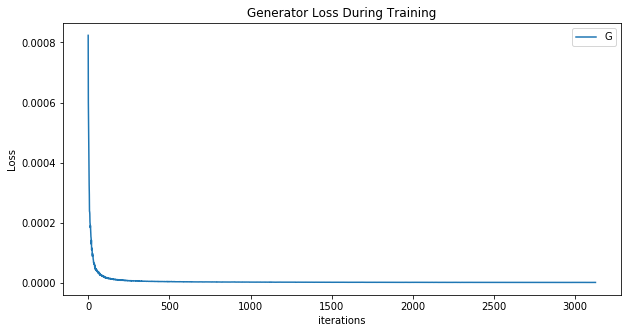

In [27]:
# loss versus training iterations
plt.figure(figsize=(10,5))
plt.title("Generator Loss During Training")
plt.plot(losses, label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

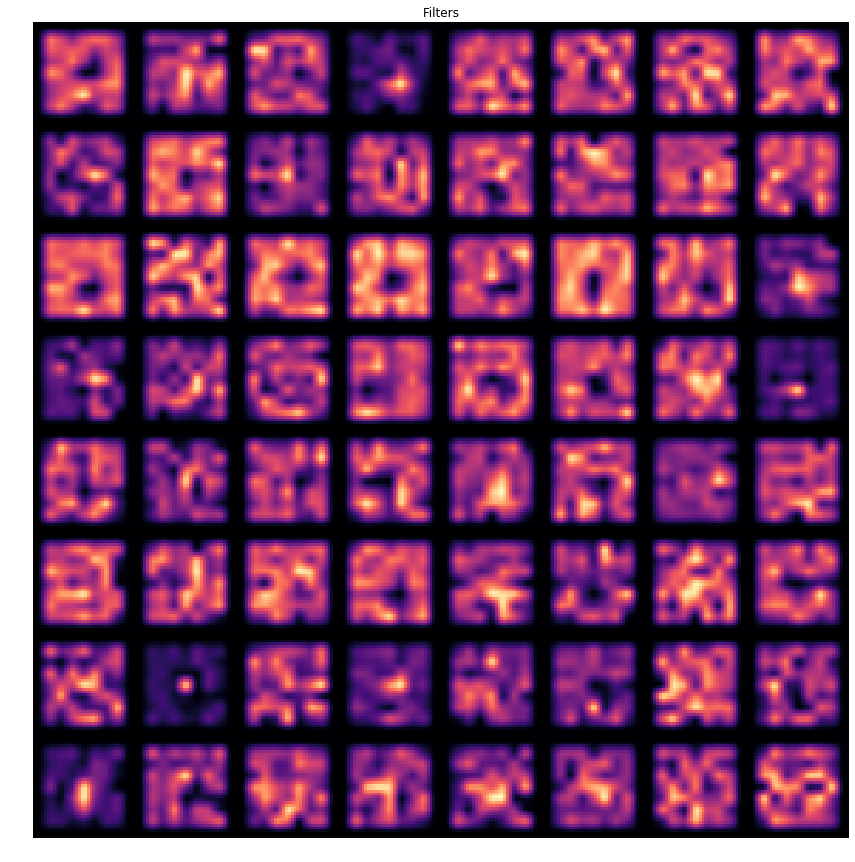

In [5]:
# viz filters
viz_filters(t, mod='conv')

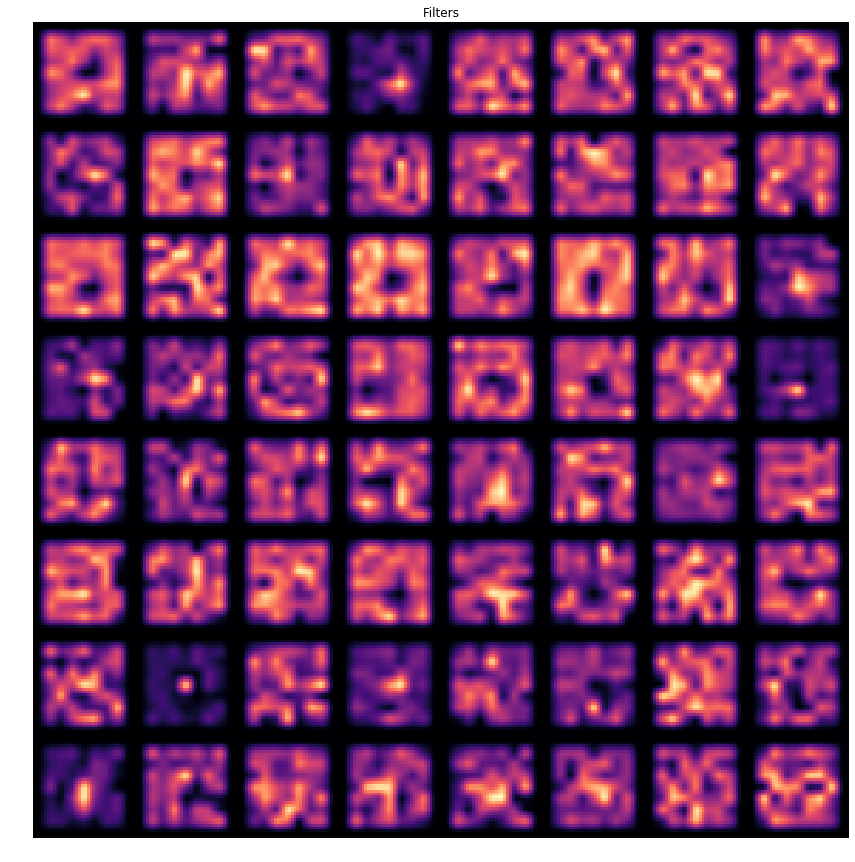

In [6]:
# viz filters
viz_filters(transform_i, mod='convt')

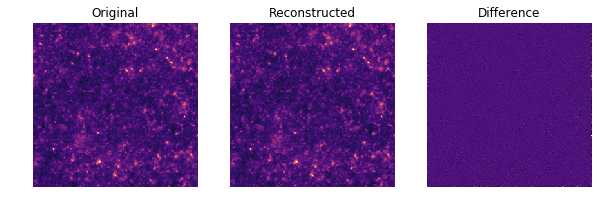

3.690363499709995e-05


In [18]:
im = mnu_dataset[25000]['image'].to(device).unsqueeze(0)
viz_im_r(im, transform_i(t(im)))
print(torch.norm(im - transform_i(t(im))).item()**2/28**2)